In [1]:
import re

import numpy as np
import pandas as pd

import torch
import torch.nn as nn

from torch.utils.data import DataLoader, Dataset
from torch.optim import *

from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

from nltk.tokenize.treebank import TreebankWordDetokenizer

import datasets
from datasets import load_dataset

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from IPython.display import  clear_output
import warnings

warnings.simplefilter("ignore")
datasets.utils.logging.set_verbosity_error()


In [2]:
class LMDataset(Dataset):
    def __init__(self, dataset, tokenizer, vocab, maxlen, special_tokens, device):
        super(LMDataset, self).__init__()

        self.maxlen = maxlen
        self.special_tokens = special_tokens

        self.tokenizer = get_tokenizer('spacy') if tokenizer is None else tokenizer
        self.vocab = self.get_vocab(dataset) if vocab is None else vocab

        sentence_pairs = dataset.map(self.create_sentence_pairs)['sentence_pairs']
        flatten_tokens = [sent for sents in sentence_pairs for sent in sents]
        flatten_tokens = pd.DataFrame(flatten_tokens).drop_duplicates().values.tolist()

        self.tokens = torch.zeros((len(flatten_tokens), self.maxlen), dtype=torch.long, device=device)
        for i, sent in enumerate(flatten_tokens):
            self.tokens[i, :] = torch.tensor(self.vocab(sent))

    def __getitem__(self, i):
        return self.tokens[i]

    def __len__(self):
        return len(self.tokens)

    def create_sentence_pairs(self, x):
        sentences = re.split(r'[\s]*#Person\d#: ', x['dialogue'])[1:]

        sentence_pairs = []
        for sent1, sent2 in zip(sentences[:-1], sentences[1:]):
            sent_pair = ' '.join([self.special_tokens['bos_token'], sent1,
                                  self.special_tokens['pad_token'], sent2])

            sent = [tok for tok in self.tokenizer(sent_pair)]
            sent = sent[:self.maxlen]
            sent = sent + [self.special_tokens['eos_token']] * (self.maxlen - len(sent))
            sentence_pairs.append(sent)

        return {'sentence_pairs': sentence_pairs}

    def get_vocab(self, dataset):
        sentence_pairs = dataset.map(self.create_sentence_pairs)['sentence_pairs']
        flatten_tokens = [sent for sents in sentence_pairs for sent in sents]
        vocab = build_vocab_from_iterator(flatten_tokens, min_freq=5,
                                          specials=list(self.special_tokens.values()))
        vocab.set_default_index(vocab['|UNK|'])

        return vocab

In [3]:
class LstmModel(nn.Module):
    def __init__(self, vocab_size, embed_dim=64, n_layers=32, n_hidden=128, dropout_rate=0.2):
        super(LstmModel, self).__init__()

        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.dropout_rate = dropout_rate

        self.embed = nn.Embedding(self.vocab_size, embedding_dim=self.embed_dim)
        self.lstm = nn.LSTM(self.embed_dim, self.n_hidden, num_layers=self.n_layers,
                            dropout=dropout_rate, batch_first=True)
        self.fc = nn.Linear(self.n_hidden, self.vocab_size)
        self.softmax = nn.LogSoftmax(dim=-1)
        
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x, states=None):
        out = self.dropout(self.embed(x))
        out, states = self.lstm(out, states)
        out = self.fc(out)
        out = self.softmax(out)
        
        return out, states

    def init_states(self, batch_size, device):
        h = torch.zeros((self.n_layers, batch_size, self.n_hidden), device=device)
        c = torch.zeros((self.n_layers, batch_size, self.n_hidden), device=device)

        return (h, c)



In [4]:
def train_step(model, loader, optimizer, criterion, device='cpu'):
    model.train()

    batch_losses = []
    for i, batch in enumerate(tqdm(loader)):
        batch = batch.to(device)

        states = model.init_states(batch.size(0), device=device)

        optimizer.zero_grad()
        states = [state.detach() for state in states]
        y_pred, states = model(batch[:, :-1], states)
        loss = criterion(y_pred.moveaxis(1, -1), batch[:, 1:])
        loss.backward()
        optimizer.step()

        batch_losses.append(loss.item())

    return np.mean(batch_losses)


def eval_step(model, loader, criterion, device):
    model.eval()

    batch_losses = []

    for i, batch in enumerate(tqdm(loader)):
        batch = batch.to(device)

        y_pred, _ = model(batch[:, :-1])
        loss = criterion(y_pred.moveaxis(1, -1), batch[:, 1:])

        batch_losses.append(loss.item())

    return np.mean(batch_losses)

def beam_search(model, tokenized_sent, num_beams, max_new_token, eos_token_id, **kwargs):
    # generate function for beam search decoding
    # model: model to generate
    # tokenized_sent: tokenized input sentence
    # num_beams: number of beams
    # max_new_token: maximum number of new tokens to generate
    # eos_token_id: end of sentence token_id for early stopping
    # **kwargs: additional arguments for model forward pass

    # get first beams
    out, states = model(tokenized_sent, kwargs.get('states'))
    top_preds = out[-1, :].topk(num_beams, dim=-1)

    # add predictions to beams
    beams = [(pred.unsqueeze(0), states, score.item()) for pred, score in zip(top_preds.indices, top_preds.values)]

    for i in range(max_new_token - 1):
        new_beams = []
        for beam in beams:
            if beam[0][-1] == eos_token_id:
                new_beams.append(beam)
                continue

            out, states = model(beam[0][-1:], beam[1])
            top_preds = out[-1, :].topk(num_beams, dim=-1)

            for pred, score in zip(top_preds.indices, top_preds.values):
                new_beams.append((torch.cat((beam[0], pred.unsqueeze(0)), dim=0), states, beam[2] + score.item()))

        beams = sorted(new_beams, key=lambda x: x[2], reverse=True)[:num_beams]

        if beams[0][0][-1] == eos_token_id:
            break

    # return the best beam and its states
    return beams[0][0], beams[0][1]


def answer(model, sent, tokenizer, vocab, maxlen, special_tokens, device):
    model.eval()

    eos_token_id = vocab[special_tokens['eos_token']]
    detokenizer = TreebankWordDetokenizer()

    sent = ' '.join([special_tokens['bos_token'], sent, special_tokens['pad_token']])
    sent = vocab(tokenizer(sent))
    sent = torch.tensor(sent, device=device)

    with torch.no_grad():
        answer, _ = beam_search(model, sent, num_beams=3, max_new_token=30, eos_token_id=eos_token_id)
        answer = vocab.lookup_tokens(answer.tolist())

        return detokenizer.detokenize(answer)


In [21]:
max_len = 100
bs = 8
lr = 1e-3
epochs = 200

embed_dim = 256
n_layers = 2
n_hidden = 256
dropout_rate = 0.2

device = 'cuda'

In [22]:
special_tokens = {'bos_token': '|BOS|',
                  'pad_token': '|PAD|',
                  'eos_token': '|EOS|',
                  'unk_token': '|UNK|'}

train_dataset = load_dataset('knkarthick/dialogsum', split='train')
val_dataset = load_dataset('knkarthick/dialogsum', split='validation')

lm_train = LMDataset(train_dataset, None, None, max_len, special_tokens, device)
lm_valid = LMDataset(val_dataset, lm_train.tokenizer, lm_train.vocab, max_len, special_tokens, device)

train_loader = DataLoader(lm_train, batch_size=bs, shuffle=True)
val_loader = DataLoader(lm_valid, batch_size=bs)

In [ ]:
df = pd.DataFrame(columns=['Training Loss', 'Validation Loss', 'Answer'])

model = LstmModel(len(lm_train.vocab), embed_dim=embed_dim, n_layers=n_layers,
                  n_hidden=n_hidden, dropout_rate=dropout_rate)
model = model.to(device)

criterion = nn.NLLLoss()
optimizer = Adam(model.parameters(), lr=lr)

train_losses, val_losses = [], []
for e in range(epochs):
    train_loss = train_step(model, train_loader, optimizer, criterion, device)
    val_loss = eval_step(model, val_loader, criterion, device)
    
    clear_output(True)
    
    df.at[e, 'Training Loss'] = train_loss
    df.at[e, 'Validation Loss'] = val_loss
    df.at[e, 'Answer']
    
    ans = answer(model, 'Hi, how are you?', lm_train.tokenizer, lm_train.vocab, max_len, special_tokens, device)
    df.at[e, 'Answer'] = ans
    print(df)
    
    torch.save(model, f'/home/sefa/Desktop/best-lstms/lstm_model{e}.pt')
    

   Training Loss Validation Loss  \
0        1.42711        1.272789   
1       1.245473        1.227878   
2        1.18613        1.213939   
3       1.149855        1.208123   
4       1.124819        1.207028   
5       1.106918         1.20725   
6       1.092709        1.207736   
7       1.081464        1.210598   
8       1.072392        1.213504   
9       1.064656        1.212746   
10      1.057844         1.21561   
11      1.051758        1.217048   
12      1.046704        1.218736   
13      1.041905        1.221013   
14      1.037862        1.223326   
15      1.034235        1.224761   
16      1.030614        1.225817   
17      1.027292        1.227552   
18      1.024308        1.230036   
19      1.021831        1.229656   

                                            Answer  
0                                I'm sorry . |EOS|  
1   I'm going to have a look at the moment . |EOS|  
2                                     Fine . |EOS|  
3                              

  0%|          | 0/11587 [00:00<?, ?it/s]

<AxesSubplot: >

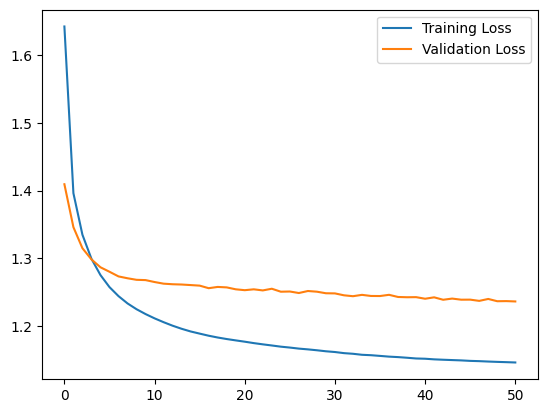

In [67]:
import matplotlib.pyplot as plt

df.plot()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('LSTM Training Results')
plt.savefig('lstm_results')

In [69]:
answer(model, 'Hi, how are you?', lm_train.tokenizer, lm_train.vocab, max_len, special_tokens, device)

"I, I can you doing |PAD| Fine Fine . I'm going to be a tourist manager . |EOS|"

In [66]:
for e in range(30, 51):
    clear_output(True)
    train_loss = train_step(model, train_loader, optimizer, criterion, device)
    val_loss = eval_step(model, val_loader, criterion, device)
    #ans = answer(model, 'Hi, how are you?', lm_train.tokenizer, lm_train.vocab, max_len, special_tokens, device)
    #print(f'\rEpoch #{e+1} -> Train Loss: {train_loss:.5f} Validation Loss: {val_loss:.5f} Answer: {ans}')

    df.at[e, 'Training Loss'] = train_loss
    df.at[e, 'Validation Loss'] = val_loss
    torch.save(model, f'Model_{e}.pt')
    print(df)

   Training Loss Validation Loss
0       1.642822        1.409476
1       1.396227        1.345987
2       1.334791        1.314821
3       1.299204        1.298289
4        1.27512        1.286632
5       1.257306        1.280024
6       1.243978        1.273138
7        1.23319        1.270393
8       1.224605        1.268107
9       1.217438        1.267676
10      1.211097        1.264829
11      1.205436        1.262399
12      1.200221        1.261547
13      1.195667        1.261138
14      1.191703         1.26033
15       1.18852        1.259505
16      1.185409        1.255706
17      1.182765        1.257577
18      1.180501        1.256893
19      1.178504        1.254059
20       1.17657        1.252769
21      1.174482        1.254047
22       1.17266        1.252417
23      1.170978        1.254909
24      1.169218        1.250509
25      1.167897        1.250804
26      1.166343        1.248564
27      1.165216        1.251548
28      1.163893        1.250533
29      1.